#Installing and Importing Libraries




In [ ]:
# NOTE: Run ini dulu, lalu restart session + run all
!pip install keras-tuner
!pip install gensim

In [ ]:
import numpy as np
import pandas as pd
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.models import Word2Vec

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from xgboost import XGBClassifier

# Deep learning
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, Dense, Dropout, GlobalMaxPooling1D, InputLayer,
    Bidirectional, GRU, BatchNormalization, Input
)
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
#Load Dataset

fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

In [ ]:
fake_df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [ ]:
#Check total data
fake_df.shape

(23481, 4)

In [ ]:
real_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [ ]:
real_df.shape

(21417, 4)

#Data Preprocessing


In [ ]:
#Adding labels to the datasets

fake_df['label'] = 1  # Fake news
real_df['label'] = 0  # Real news

In [ ]:
#Combining the datasets as one

data = pd.concat([fake_df, real_df], ignore_index=True)

data.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1

In [ ]:
#Total Data
data.shape

(44898, 5)

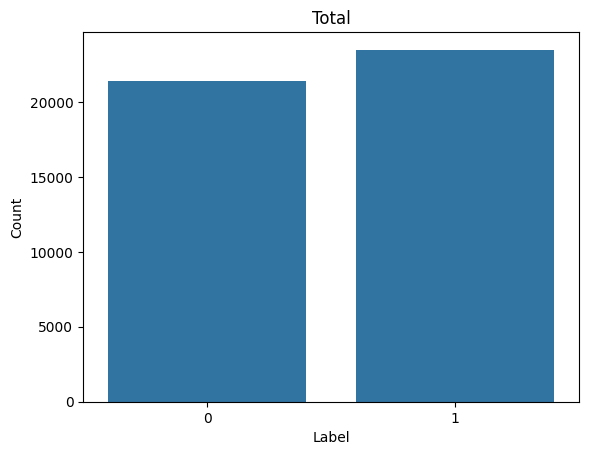

In [ ]:
sns.countplot(x='label', data=data)
plt.title('Total')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
#Dropping the Title, Subject, Date Columns
#Relevant Feature: Model bakal di training dengan isi dari beritanya aja

df = data.drop(["title", "subject","date"], axis = 1)
df.head()

text  label
0  Donald Trump just couldn t wish all Americans ...      1
1  House Intelligence Committee Chairman Devin Nu...      1
2  On Friday, it was revealed that former Milwauk...      1
3  On Christmas day, Donald Trump announced that ...      1
4  Pope Francis used his annual Christmas Day mes...      1

In [ ]:
#Check for Null Values, Make sure "No Garbage in, Garbage Out"

df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# Shuffling data
data = df.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # Required for lemmatization

def enhanced_text_cleaning(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase first for consistency
    text = text.lower()

    # Handle social media and news agency references
    # Remove "pic twitter com" and anything that follows it on the same word
    text = re.sub(r'pic\.?twitter\.?com\S*', ' ', text)
    text = re.sub(r'twitter\.com\S*', ' ', text)

    # Remove references to common news/media sources
    news_agencies = ['reuters', 'ap', 'afp', 'getty image', 'getty images', 'flickr',
                     'instagram', 'facebook', 'youtube', 'washington post']
    for agency in news_agencies:
        text = re.sub(rf'\b{agency}\b.*?(?=\s|$)', ' ', text)

    # Remove content after "via" (common citation pattern)
    text = re.sub(r'\svia \s.*?(?=\.|$)', ' ', text)

    # Remove URL fragments that might be broken incorrectly
    text = re.sub(r'\w+\.com\S*', ' ', text)
    text = re.sub(r'\w+\.co\S*', ' ', text)
    text = re.sub(r'\w+\.org\S*', ' ', text)

    # Remove specific common patterns in your dataset
    text = re.sub(r'eoklflkiqy', ' ', text)
    text = re.sub(r'eugwd', ' ', text)

    # Remove standard social media indicators
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', ' ', text)  # Remove RT
    text = re.sub(r'https?://\S+', ' ', text)  # Remove URLs
    text = re.sub(r'http\S+', ' ', text)  # Remove other links

    # Identify and separate joined words (common in social media content)
    # Look for patterns like "anothernight" -> "another night"
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  # Split camelCase


    # Remove month+year patterns
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{4}\b', ' ', text)

    # Enhanced spacing around punctuation
    text = re.sub(r'([.,!?:;\(\)\[\]{}"\'-])', r' \1 ', text)

    # Fix additional word joining issues
    text = re.sub(r'(\w)(\d)', r'\1 \2', text)  # Split words and numbers
    text = re.sub(r'(\d)(\w)', r'\1 \2', text)  # Split numbers and words

    # Replace remaining non-alphanumeric with spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Normalize spaces and remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Add more specific words to remove beyond standard stopwords
    custom_stopwords = ['image', 'photo', 'picture', 'pic', 'reuters', 'said', 'say', 'says',
                        'via', 'getty', 'afp', 'jpg', 'jpeg', 'png', 'video', 'screenshots', 'screenshot', 'gateway pundit']

    # Combine with standard stopwords
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    words = text.split()

    # Filter words by length and stopword status
    text = ' '.join([word for word in words if word not in stop_words and len(word) > 2])

    return text.strip()

def apply_stemming(text):
    stemmer = PorterStemmer()
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

def apply_lemmatization(text):
    """Apply lemmatization for more natural word forms"""
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

def check_token_length(text, min_words=10):
    """
    Check if the text has enough tokens after preprocessing
    If not, return the original text with stopwords preserved
    """
    words = text.split()
    if len(words) < min_words:
        # If too short, keep stopwords but maintain other cleaning
        text_with_stopwords = enhanced_text_cleaning(text)
        words_with_stopwords = text_with_stopwords.split()
        return ' '.join([word for word in words_with_stopwords if len(word) > 2])
    return text

def improved_preprocess_text(text, use_stemming=False, use_lemmatization=True, min_token_length=10):
    """
    Complete preprocessing pipeline with enhanced social media pattern removal
    """
    # Basic cleaning with enhanced spacing and social media pattern removal
    text = enhanced_text_cleaning(text)

    # Apply stemming or lemmatization (not both)
    if use_lemmatization:
        text = apply_lemmatization(text)
    elif use_stemming:
        text = apply_stemming(text)

    # Verify the text isn't too short after processing
    text = check_token_length(text, min_token_length)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


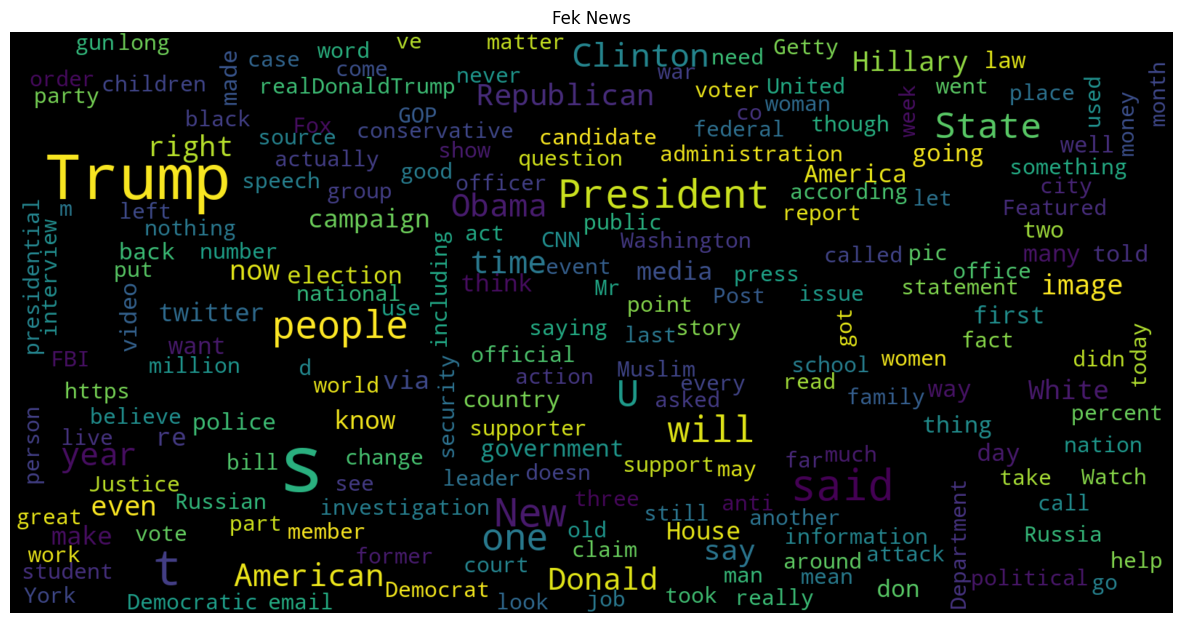

In [ ]:
#Visualising WordCloud (to get a visual look of the most used words)

consolidated = ' '.join(
    word for word in data['text'][data['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.title('Fek News')
plt.show()

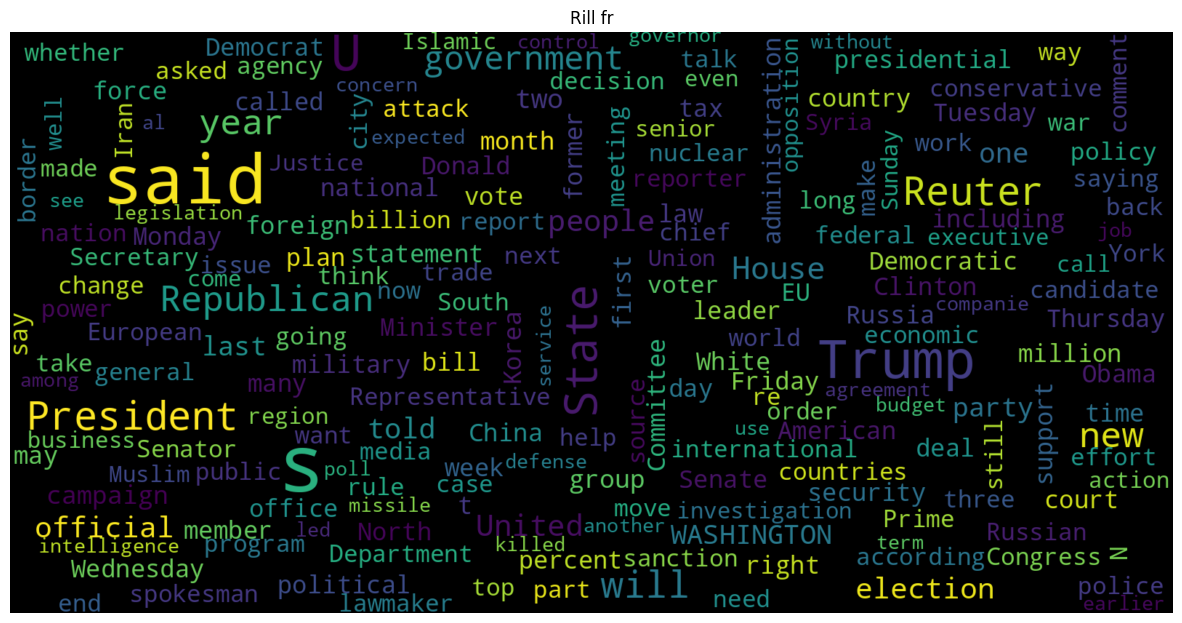

In [ ]:
#Real News

consolidated = ' '.join(
    word for word in data['text'][data['label'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.title('Rill fr')
plt.show()

In [ ]:
# Function to analyze token length distribution
def analyze_token_distribution(texts, title="Token Length Distribution"):
    token_lengths = [len(text.split()) for text in texts]

    print(f"\n{title}:")
    print(f"Mean token length: {np.mean(token_lengths):.2f}")
    print(f"Median token length: {np.median(token_lengths):.2f}")
    print(f"Min token length: {min(token_lengths)}")
    print(f"Max token length: {max(token_lengths)}")

    # Count texts with fewer than 10 tokens
    short_texts = sum(1 for length in token_lengths if length < 10)
    print(f"Texts with fewer than 10 tokens: {short_texts} ({short_texts/len(token_lengths)*100:.2f}%)")

    # Visualize token length distribution (optional)
    plt.figure(figsize=(10, 6))
    plt.hist(token_lengths, bins=30, alpha=0.7)
    plt.title(f"{title}")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Show most common words
    all_words = []
    for text in texts:
        all_words.extend(text.split())

    word_counts = Counter(all_words)
    print("\nMost common words:")
    for word, count in word_counts.most_common(20):
        print(f"{word}: {count}")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...

Training Set Token Distribution:
Mean token length: 222.98
Median token length: 196.00
Min token length: 0
Max token length: 4806
Texts with fewer than 10 tokens: 900 (2.51%)


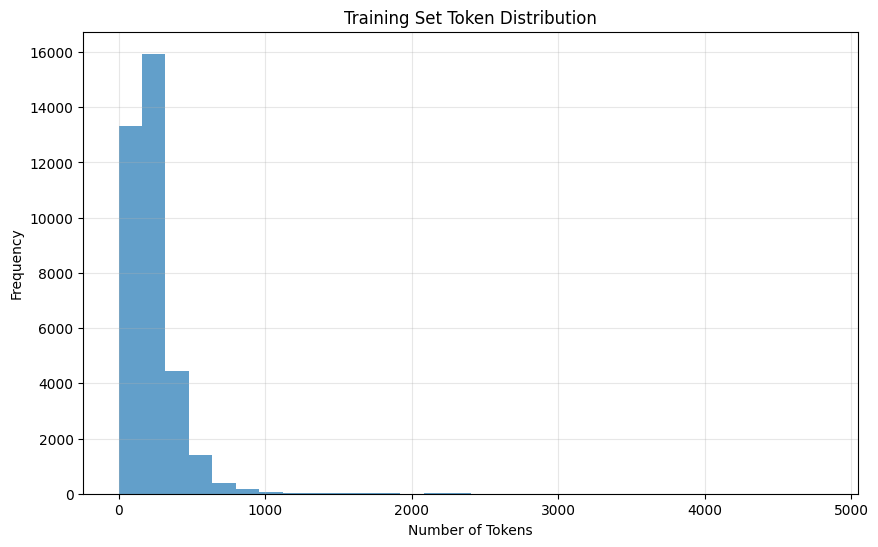


Most common words:
trump: 107705
state: 49175
president: 45990
would: 44271
people: 33643
year: 33484
republican: 31879
one: 31349
new: 25181
also: 25153
clinton: 23954
government: 23875
time: 23229
obama: 22882
house: 22822
donald: 22583
american: 20484
country: 20464
election: 20336
party: 19293

Validation Set Token Distribution:
Mean token length: 219.63
Median token length: 193.00
Min token length: 0
Max token length: 4729
Texts with fewer than 10 tokens: 111 (2.47%)


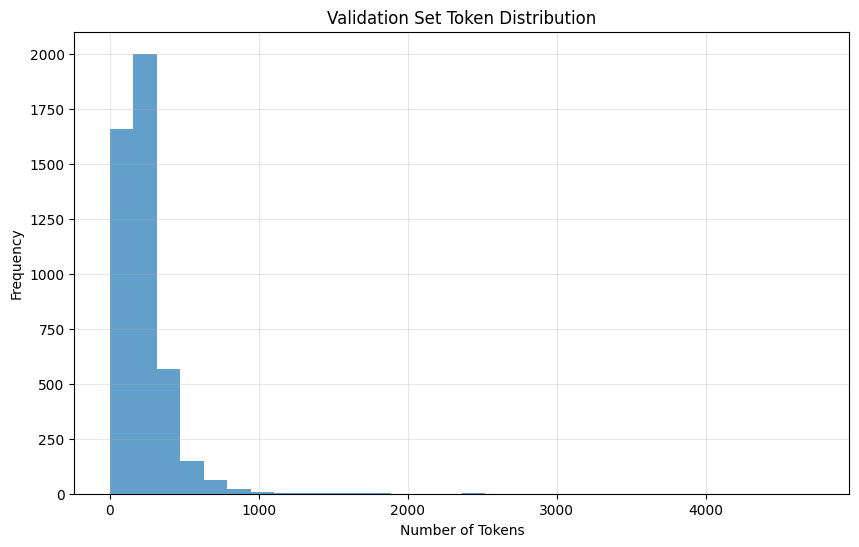


Most common words:
trump: 13273
state: 6035
president: 5570
would: 5529
people: 4261
republican: 4133
year: 4002
one: 3857
new: 3151
also: 3090
obama: 2862
clinton: 2855
time: 2809
government: 2791
house: 2789
donald: 2761
american: 2640
country: 2518
could: 2393
white: 2374

Validation Set Token Distribution:
Mean token length: 217.88
Median token length: 194.00
Min token length: 0
Max token length: 3441
Texts with fewer than 10 tokens: 95 (2.12%)


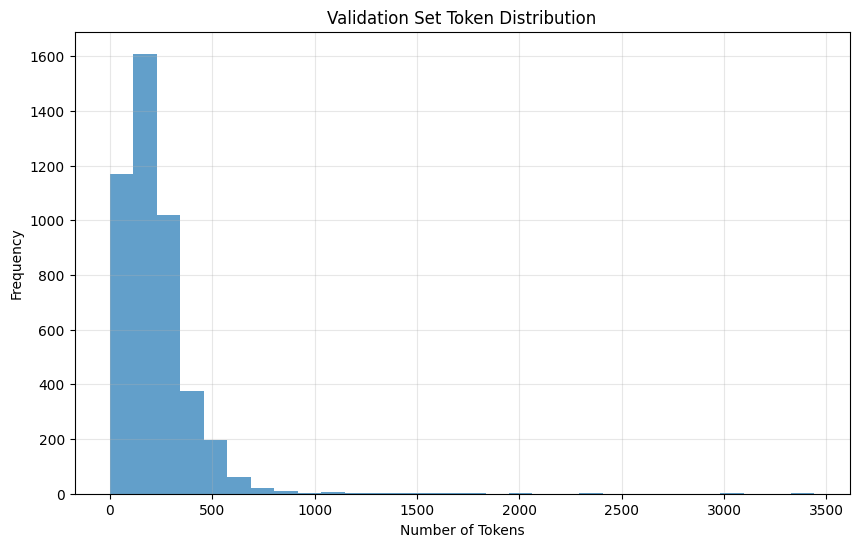


Most common words:
trump: 13284
state: 6090
president: 5500
would: 5341
year: 4187
people: 4082
one: 3970
republican: 3670
also: 3114
government: 3021
new: 2992
donald: 2805
time: 2793
house: 2699
country: 2606
clinton: 2587
right: 2481
american: 2480
could: 2479
obama: 2450


In [ ]:
# Train Test Split, 80 Training : 20 Testing
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Splits the Testing into 50:50 (10% val, 10% test)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Apply preprocessing
print("Preprocessing training data...")
train_df['text'] = train_df['text'].apply(lambda x: improved_preprocess_text(x,
                                                       use_stemming=False,
                                                       use_lemmatization=True,
                                                       min_token_length=10))

print("Preprocessing validation data...")
val_df['text'] = val_df['text'].apply(lambda x: improved_preprocess_text(x,
                                                     use_stemming=False,
                                                     use_lemmatization=True,
                                                     min_token_length=10))

print("Preprocessing test data...")
test_df['text'] = test_df['text'].apply(lambda x: improved_preprocess_text(x,
                                                   use_stemming=False,
                                                   use_lemmatization=True,
                                                   min_token_length=10))

# Extract text and labels
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

# Check token distribution to ensure preprocessing isn't making texts too short
analyze_token_distribution(train_texts, "Training Set Token Distribution")
analyze_token_distribution(val_texts, "Validation Set Token Distribution")
analyze_token_distribution(test_texts, "Validation Set Token Distribution")

In [ ]:
train_texts

['president obama asked press conference thought likelihood donald trump presidency pulling punch laid exactly donald trump never president continue believe trump president reason lot faith american people think recognize president serious job hosting talk show reality show promotion marketing hard lot people count getting right matter pandering whatever get news given day source hillwhile president obama maintained normally cool demeanor smooth delivery still managed deliver described hell sick burn trump people support carnival barker shenanigan trump qualification president obama know american people know supporter third republican fringe run pure emotion otherwise clueless civics government work president obama restrict criticism trump also took opportunity dig hard marco rubio blistering comment flip flopping order pander trump effect country around world kind count united state side science reason common sense single candidate republican primary think anything climate change thin

In [ ]:
val_texts

['bangkok ousted thai prime minister yingluck shinawatra fled country ahead verdict negligence trial brought junta overthrew source close shinawatra family friday yingluck whose family dominated thai politics year failed show court judgment case centered multi billion dollar loss incurred rice subsidy scheme farmer overthrown yingluck faced year prison found guilty former commerce minister jailed related case year friday definitely left thailand one source also member puea thai party source gone yingluck brother thaksin shinawatra head political clan overthrown coup fled exile escape corruption conviction aimed demolishing populist movement founded struggle movement bangkok centered royalist pro military elite heart year turmoil thailand verdict yingluck could reignited tension though army largely snuffed open opposition yingluck failed show supreme court issued arrest warrant rescheduled verdict sept believe excuse could attend court hearing ear problem possible fled already deputy pr

In [ ]:
train_texts

['president obama asked press conference thought likelihood donald trump presidency pulling punch laid exactly donald trump never president continue believe trump president reason lot faith american people think recognize president serious job hosting talk show reality show promotion marketing hard lot people count getting right matter pandering whatever get news given day source hillwhile president obama maintained normally cool demeanor smooth delivery still managed deliver described hell sick burn trump people support carnival barker shenanigan trump qualification president obama know american people know supporter third republican fringe run pure emotion otherwise clueless civics government work president obama restrict criticism trump also took opportunity dig hard marco rubio blistering comment flip flopping order pander trump effect country around world kind count united state side science reason common sense single candidate republican primary think anything climate change thin

Training class distribution:
1    0.52425
0    0.47575
Name: proportion, dtype: float64

Validation class distribution:
1    0.521826
0    0.478174
Name: proportion, dtype: float64

Test class distribution:
1    0.514031
0    0.485969
Name: proportion, dtype: float64


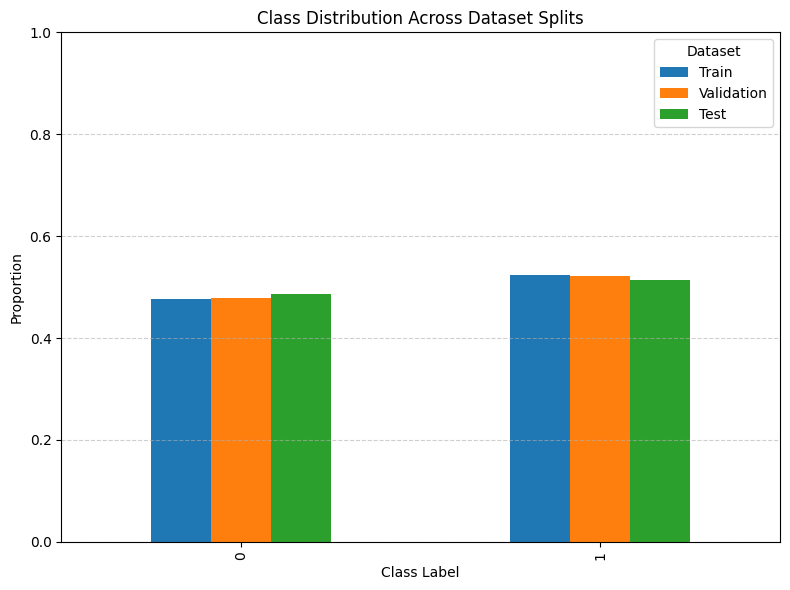

In [ ]:
# Calculate class distributions
train_dist = pd.Series(train_labels).value_counts(normalize=True)
val_dist = pd.Series(val_labels).value_counts(normalize=True)
test_dist = pd.Series(test_labels).value_counts(normalize=True)

print("Training class distribution:")
print(train_dist)
print("\nValidation class distribution:")
print(val_dist)
print("\nTest class distribution:")
print(test_dist)

# Combine into a DataFrame for plotting
dist_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
}).fillna(0)  # In case a class is missing in a split

# Sort index for consistency
dist_df = dist_df.sort_index()

# Plot
dist_df.plot(kind='bar', figsize=(8, 6))
plt.title('Class Distribution Across Dataset Splits')
plt.xlabel('Class Label')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

#Feature Engineering



In [ ]:
train_tokens = [text.split() for text in train_texts]
val_tokens = [text.split() for text in val_texts]
test_tokens = [text.split() for text in test_texts]

# Train Word2Vec model on the training data
w2v_model = Word2Vec(sentences=train_tokens, vector_size=50, window=5, min_count=1, workers=4)

# Convert tokens to Word2Vec vectors
def tokens_to_vectors(tokens, model, max_len):
    vectors = []
    for sentence in tokens:
        sentence_vec = []
        for word in sentence:
            if word in model.wv:
                sentence_vec.append(model.wv[word])
            else:
                sentence_vec.append(np.zeros(model.vector_size))  # Zero vector for unknown words
        # Padding or truncating to max_len
        if len(sentence_vec) < max_len:
            pad_len = max_len - len(sentence_vec)
            sentence_vec.extend([np.zeros(model.vector_size)] * pad_len)
        else:
            sentence_vec = sentence_vec[:max_len]
        vectors.append(sentence_vec)
    return np.array(vectors)

# Convert the text to Word2Vec vectors with padding/truncation
max_len = 64
train_sequences = tokens_to_vectors(train_tokens, w2v_model, max_len)
val_sequences = tokens_to_vectors(val_tokens, w2v_model, max_len)
test_sequences = tokens_to_vectors(test_tokens, w2v_model, max_len)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# Print dataset sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Testing set size: {len(test_df)}")


Training set size: 35918
Validation set size: 4490
Testing set size: 4490


#Model Training




In [ ]:
# Define improved model builder with two GRU layers and regularization

def build_optimized_model(hp):
    model = Sequential()

    # Input layer
    model.add(InputLayer(input_shape=(max_len, w2v_model.vector_size)))

    # First Bidirectional GRU layer with comprehensive regularization
    model.add(Bidirectional(GRU(
        hp.Int('gru_units_1', min_value=16, max_value=48, step=8),
        return_sequences=True,
        recurrent_dropout=hp.Float('recurrent_dropout_1', min_value=0.05, max_value=0.2, step=0.05),
        recurrent_regularizer=l2(hp.Float('recurrent_reg', min_value=1e-6, max_value=1e-4, sampling='log')),
        kernel_regularizer=l2(hp.Float('kernel_reg', min_value=1e-6, max_value=1e-4, sampling='log')),
        bias_regularizer=l2(hp.Float('bias_reg', min_value=1e-6, max_value=1e-4, sampling='log'))
    )))
    model.add(BatchNormalization())

    # Second Bidirectional GRU layer
    model.add(Bidirectional(GRU(
        hp.Int('gru_units_2', min_value=12, max_value=32, step=4),
        return_sequences=True,
        recurrent_dropout=hp.Float('recurrent_dropout_2', min_value=0.05, max_value=0.2, step=0.05)
    )))
    model.add(BatchNormalization())

    # Global pooling
    model.add(GlobalMaxPooling1D())

    # First dense layer with regularization
    model.add(Dropout(hp.Float('dropout_rate1', min_value=0.2, max_value=0.4, step=0.05)))
    model.add(Dense(
        hp.Int('dense_units', min_value=16, max_value=32, step=8),
        activation='relu',
        kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=0.0001, max_value=0.001, step=0.0001)),
        kernel_initializer='he_normal'
    ))

    # Second dropout layer
    model.add(Dropout(hp.Float('dropout_rate2', min_value=0.2, max_value=0.4, step=0.05)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile with tunable learning rate and gradient clipping
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=5e-5, max_value=5e-4, sampling='log'),
            clipnorm=hp.Choice('clipnorm', values=[0.5, 1.0, 1.5]),
            beta_1=0.9,
            beta_2=0.999
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize the tuner with more trials for better exploration
tuner = kt.RandomSearch(
    build_optimized_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_results',
    project_name='optimized_fake_news_brnn_gru'
)

# Search with more epochs and reduced batch size for better gradient estimates
tuner.search(
    train_sequences, train_labels,
    epochs=5,
    validation_data=(val_sequences, val_labels),
    batch_size=256,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    shuffle=True
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print comprehensive hyperparameter information
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best GRU units (layer 1): {best_hps.get('gru_units_1')}")
print(f"Best GRU units (layer 2): {best_hps.get('gru_units_2')}")
print(f"Best recurrent dropout (layer 1): {best_hps.get('recurrent_dropout_1')}")
print(f"Best recurrent dropout (layer 2): {best_hps.get('recurrent_dropout_2')}")
print(f"Best dense units: {best_hps.get('dense_units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best gradient clipnorm: {best_hps.get('clipnorm')}")
print(f"Best dropout rates: {best_hps.get('dropout_rate1')}, {best_hps.get('dropout_rate2')}")


Reloading Tuner from tuner_results/optimized_fake_news_brnn_gru/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Best GRU units (layer 1): 48
Best GRU units (layer 2): 32
Best recurrent dropout (layer 1): 0.2
Best recurrent dropout (layer 2): 0.05
Best dense units: 24
Best learning rate: 0.0002665379617868159
Best gradient clipnorm: 0.5
Best dropout rates: 0.25, 0.35000000000000003


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Create enhanced callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


# Train the best model with comprehensive callbacks
history = best_model.fit(
    train_sequences, train_labels,
    epochs=10,
    batch_size=256,
    validation_data=(val_sequences, val_labels),
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 77s 443ms/step - accuracy: 0.7936 - loss: 0.5318 - val_accuracy: 0.9419 - val_loss: 0.1710 - learning_rate: 2.6654e-04
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 429ms/step - accuracy: 0.9322 - loss: 0.1938 - val_accuracy: 0.9586 - val_loss: 0.1230 - learning_rate: 2.6654e-04
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.9518 - loss: 0.1474 - val_accuracy: 0.9657 - val_loss: 0.1032 - learning_rate: 2.6654e-04
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 61s 431ms/step - accuracy: 0.9619 - loss: 0.1202 - val_accuracy: 0.9699 - val_loss: 0.0915 - learning_rate: 2.6654e-04
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.9655 - loss: 0.1129 - val_accuracy: 0.9742 - val_loss: 0.0842 - learning_rate: 2.6654e-04
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 426ms/step - accuracy: 0.9723 - loss: 0.0965 - val_accuracy: 0.9753 - val_loss: 0.0796 - learning_rate: 2.6654e-04
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 43

In [ ]:
# Logistic Regression

train_sequences_flat = train_sequences.reshape(train_sequences.shape[0], -1)
test_sequences_flat = test_sequences.reshape(test_sequences.shape[0], -1)

print("Training Logistic Regression model...")
log_reg = LogisticRegression(max_iter=1000) #Finding the best fit from 1000 attempts
log_reg.fit(train_sequences_flat, train_labels)
print("Completed")
log_reg_pred = log_reg.predict(test_sequences_flat)

Training Logistic Regression model...
Completed


In [ ]:
# Decision

print("Training Descision Tree model...")
dtree = DecisionTreeClassifier(max_depth=10, random_state=42)
dtree.fit(train_sequences_flat, train_labels)
print("Completed")

dtree_pred = dtree.predict(test_sequences_flat)

Training Descision Tree model...
Completed


In [ ]:
#Random forest

print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(train_sequences_flat, train_labels)
print("Completed")

rf_pred = rf_model.predict(test_sequences_flat)

Training Random Forest model...
Completed


In [ ]:
# XGBoost

print("Training XGBoost model...")
xgb_model = XGBClassifier(
    n_estimators=100,        # Number of boosting rounds (trees)
    learning_rate=0.1,       # Step size (like in Gradient Boosting)
    max_depth=5,            # Depth of each tree
    n_jobs=-1,
    random_state=42,         # Seed for reproducibility
    verbosity=1
)

# Fit the model
xgb_model.fit(train_sequences_flat, train_labels)
print("Completed")

# Make predictions
xgb_pred = xgb_model.predict(test_sequences_flat)

Training XGBoost model...
Completed


In [ ]:
# Scale the Word2Vec embeddings to the range [0, 1]
scaler = MinMaxScaler()
train_sequences_flat = scaler.fit_transform(train_sequences_flat)
test_sequences_flat = scaler.transform(test_sequences_flat)

print("Training Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(train_sequences_flat, train_labels)
print("Completed")

nb_pred = nb_model.predict(test_sequences_flat)

Training Naive Bayes model...
Completed


In [ ]:
print("Scaling features for SVM...")

# Scale features for better SVM performance
scaler = StandardScaler()
train_sequences_scaled = scaler.fit_transform(train_sequences_flat)
test_sequences_scaled = scaler.transform(test_sequences_flat)

print("Training SVM model...")
svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42, max_iter=1000)
svm_model.fit(train_sequences_scaled, train_labels)
print("SVM training completed.")

svm_pred = svm_model.predict(test_sequences_scaled)

Scaling features for SVM...
Training SVM model...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM training completed.


#Model Evaluation



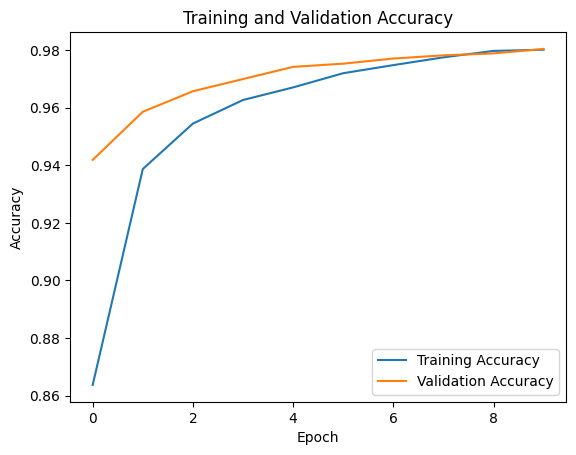

In [ ]:
# Good Training and Validation = Chart goes Up

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

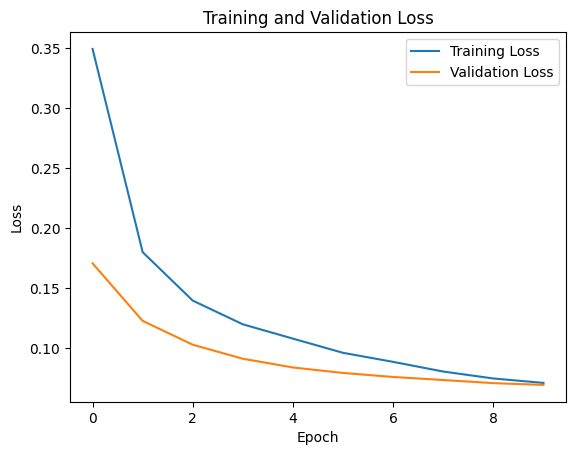

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Function to calculate and display comprehensive metrics

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Create and display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step

RNN BIGRU Evaluation Metrics:
Accuracy:  0.9820
Precision: 0.9818
Recall:    0.9831
F1 Score:  0.9825


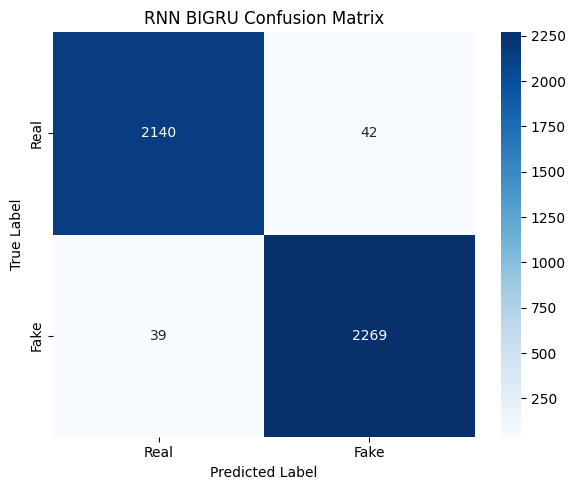

In [ ]:
# Evaluate RNN BIGRU model
y_pred_probs = best_model.predict(test_sequences)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
rnn_metrics = evaluate_model(test_labels, y_pred_classes, "RNN BIGRU")


Logistic Regression Evaluation Metrics:
Accuracy:  0.9561
Precision: 0.9497
Recall:    0.9658
F1 Score:  0.9577


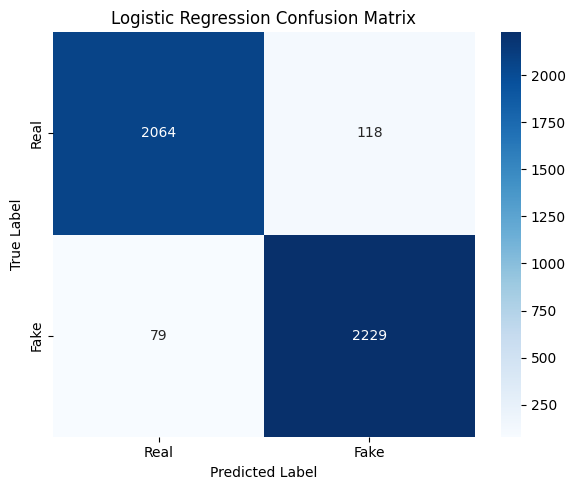

In [ ]:
# Evaluate Logistic Regression model
lr_metrics = evaluate_model(test_labels, log_reg_pred, "Logistic Regression")


Decision Tree Evaluation Metrics:
Accuracy:  0.9459
Precision: 0.9381
Recall:    0.9580
F1 Score:  0.9479


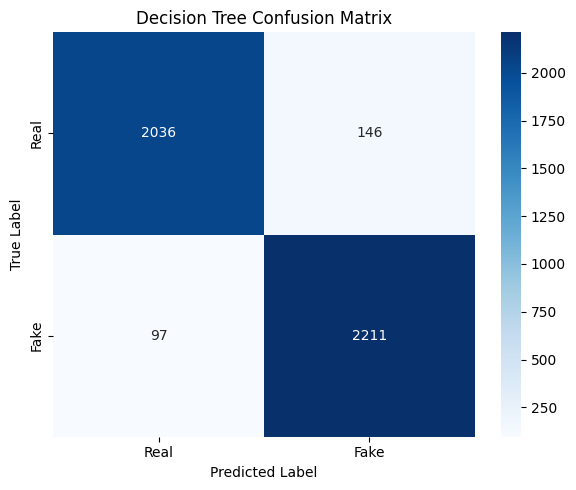

In [ ]:
# Evaluate Decision Tree model
dt_metrics = evaluate_model(test_labels, dtree_pred, "Decision Tree")


Random Forest Evaluation Metrics:
Accuracy:  0.9566
Precision: 0.9321
Recall:    0.9874
F1 Score:  0.9590


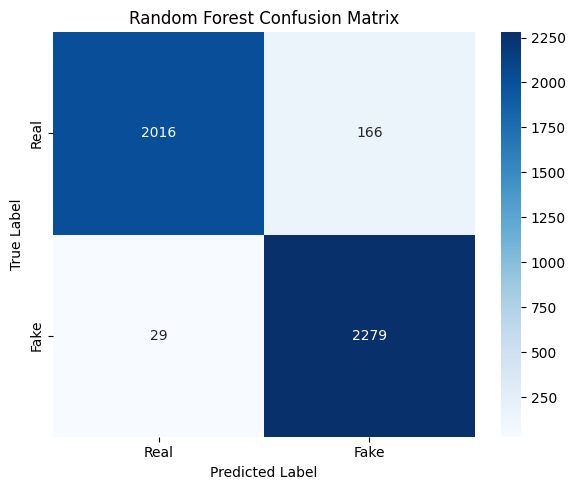

In [ ]:
# Evaluate Random Forest model
rf_metrics = evaluate_model(test_labels, rf_pred, "Random Forest")


XGBoost Evaluation Metrics:
Accuracy:  0.9708
Precision: 0.9575
Recall:    0.9870
F1 Score:  0.9721


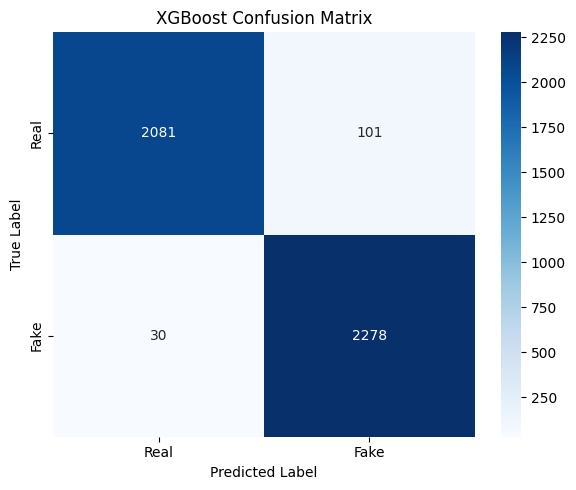

In [ ]:
# Evaluate XGBoost model
xgb_metrics = evaluate_model(test_labels, xgb_pred, "XGBoost")


Naive Bayes Evaluation Metrics:
Accuracy:  0.9125
Precision: 0.8985
Recall:    0.9354
F1 Score:  0.9166


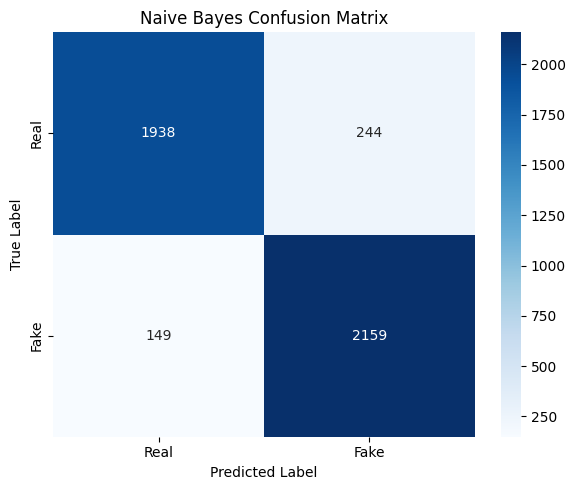

In [ ]:
# Evaluate Naive Bayes model
nb_metrics = evaluate_model(test_labels, nb_pred, "Naive Bayes")


Support Vector Machine Evaluation Metrics:
Accuracy:  0.9294
Precision: 0.9360
Recall:    0.9259
F1 Score:  0.9310


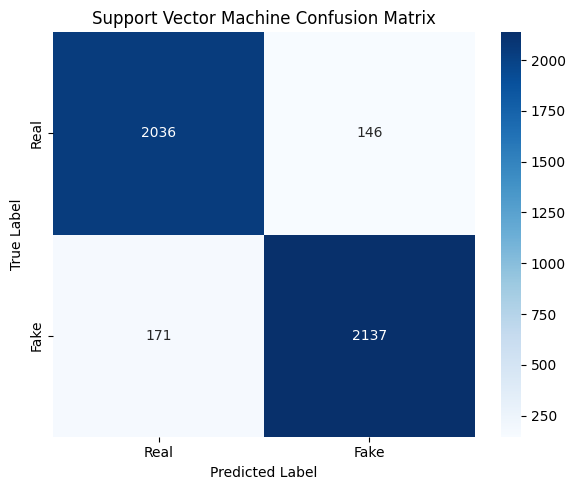

In [ ]:
# Evaluate SVM model
svm_metrics = evaluate_model(test_labels, svm_pred, "Support Vector Machine")

In [ ]:
# Compare all models in a single visualization
model_names = ['RNN BIGRU', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Naive Bayes', 'SVM']
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = np.array([rnn_metrics, lr_metrics, dt_metrics, rf_metrics, xgb_metrics, nb_metrics, svm_metrics])

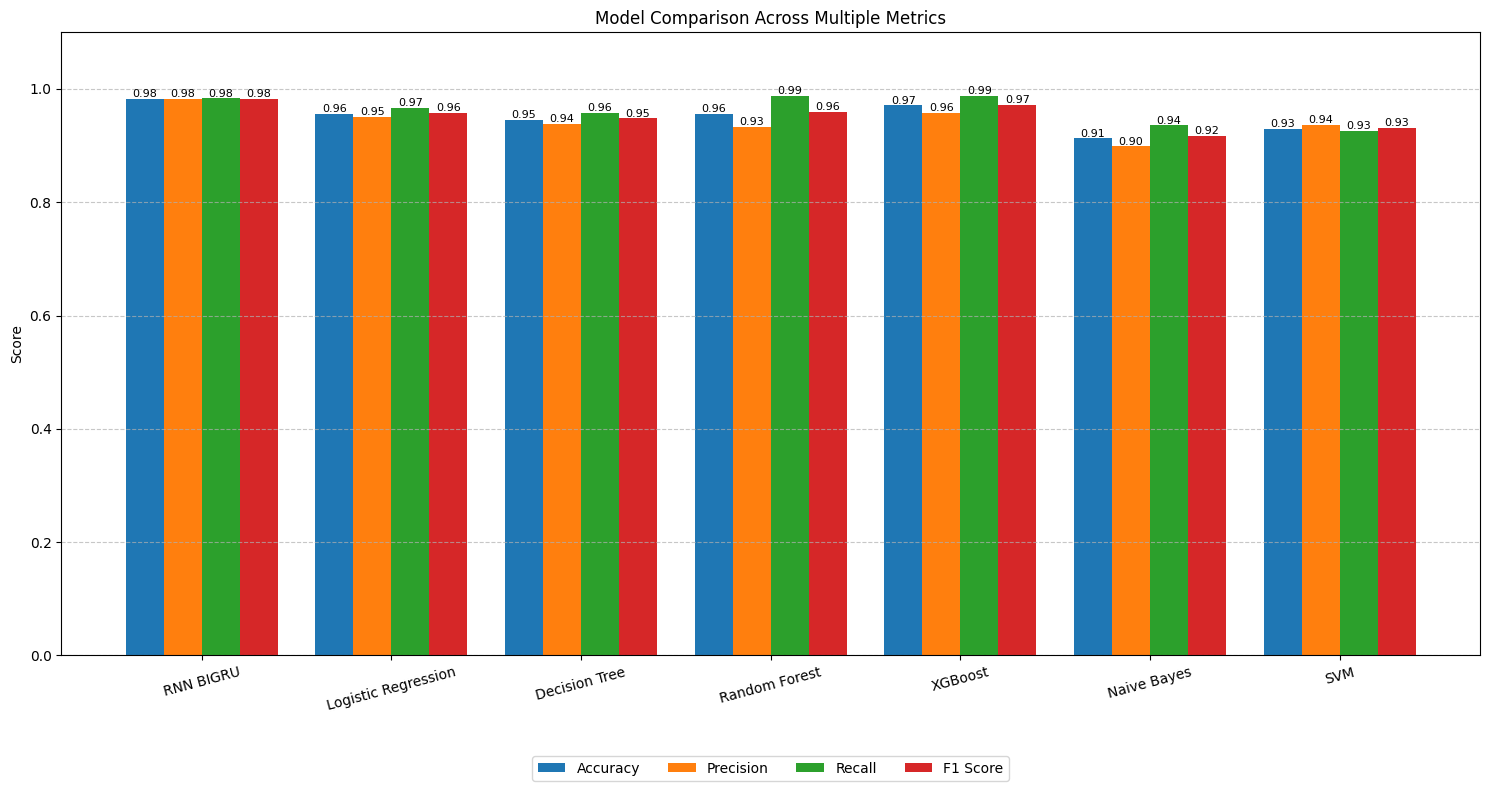

In [ ]:
# Plot comparative bar chart
plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.2
multiplier = 0

for i, metric in enumerate(metrics_names):
    offset = width * multiplier
    bars = plt.bar(x + offset, metrics_values[:, i], width, label=metric)
    plt.bar_label(bars, fmt='%.2f', fontsize=8)
    multiplier += 1

plt.ylabel('Score')
plt.title('Model Comparison Across Multiple Metrics')
plt.xticks(x + width*1.5, model_names, rotation=15)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylim(0, 1.1)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

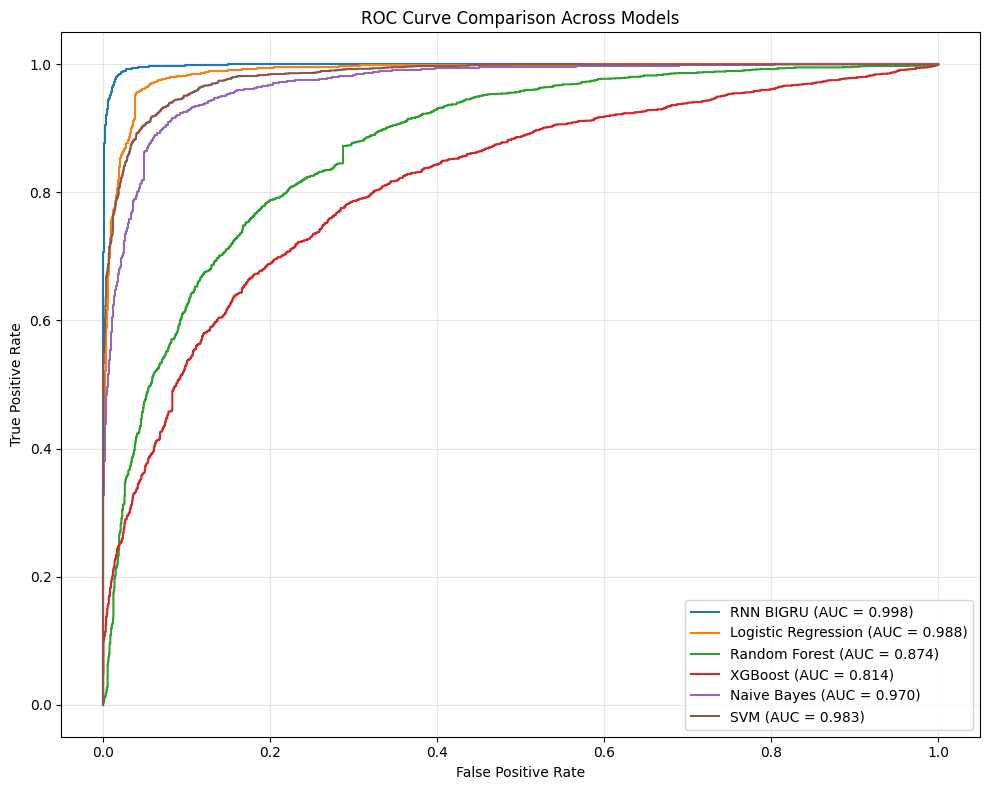

In [ ]:
# ROC Curve comparison (for models that support probability outputs)
plt.figure(figsize=(10, 8))

# RNN BIGRU
fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'RNN BIGRU (AUC = {roc_auc:.3f})')

# Logistic Regression
lr_probs = log_reg.predict_proba(test_sequences_flat)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, lr_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})')

# Random Forest
rf_probs = rf_model.predict_proba(test_sequences_flat)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, rf_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')

# XGBoost
xgb_probs = xgb_model.predict_proba(test_sequences_flat)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, xgb_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')

# Naive Bayes
nb_probs = nb_model.predict_proba(test_sequences_flat)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, nb_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.3f})')

# SVM
svm_probs = svm_model.predict_proba(test_sequences_scaled)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, svm_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.3f})')


# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Across Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Print the best model based on F1 score
all_metrics = np.array([rnn_metrics, lr_metrics, dt_metrics, rf_metrics, xgb_metrics, nb_metrics, svm_metrics])
best_model_idx = np.argmax(all_metrics[:, 3])  # F1 Score index
print(f"\nBest performing model based on F1 score: {model_names[best_model_idx]}")
print(f"F1 Score: {all_metrics[best_model_idx, 3]:.4f}")


Best performing model based on F1 score: RNN BIGRU
F1 Score: 0.9825
